In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
import imageio
import torch
import torchvision


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def plot_img_tensor(img, nrow=4):
    """Helper function to plot image tensors.
    
    Args:
        img (torch.Tensor): Image or batch of images of shape 
            (batch_size, channels, height, width).
    """
    img_grid = torchvision.utils.make_grid(img, nrow=nrow)
    plt.imshow(img_grid.cpu().numpy().transpose(1, 2, 0))

# Equivariant Neural Rendering

This notebook contains examples of how to load a trained Equivariant Neural Renderer and use it to infer scene representations from a single image, as well as rendering novel views of the scene.

## Load trained model

In [16]:
from models.neural_renderer import load_model

# Load trained chairs model
model = load_model('trained-models/chairs.pt').to(device)

## Load image

/scratch/ipykernel_8427/454371865.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread('imgs/example-data/chair4.png')


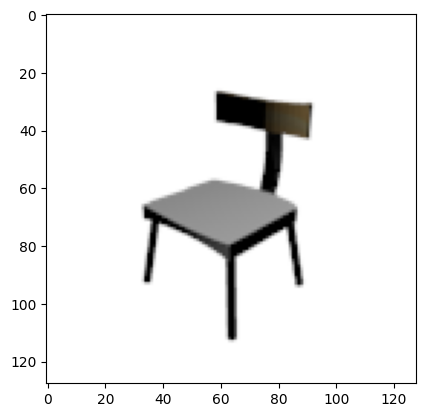

In [17]:
# You can also try loading other examples (e.g. 'chair1.png')
img = imageio.imread('imgs/example-data/chair4.png')
# Visualize image
plt.imshow(img)

## Infer and render scene representation

In [18]:
from torchvision.transforms import ToTensor

# Convert image to tensor and add batch dimension
img_source = ToTensor()(img)
img_source = img_source.unsqueeze(0).to(device)

# Infer scene representation
scene = model.inverse_render(img_source)

# Print scene shape
print("Scene shape: {}".format(scene.shape))

Scene shape: torch.Size([1, 64, 32, 32, 32])


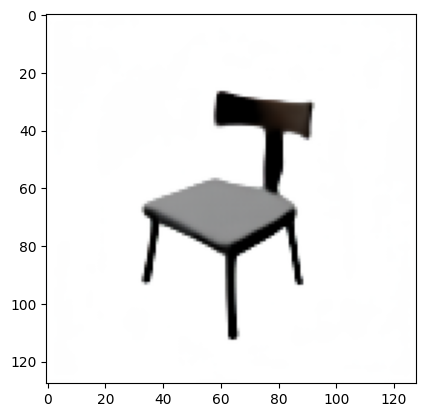

In [19]:
# We can render the scene representation without rotating it
rendered = model.render(scene)

plot_img_tensor(rendered.detach())

org = rendered.detach().clone()

## Generate novel views

In [20]:
# # Initialize a rotation matrix
# rotation_matrix = torch.Tensor(
#    [[[ 0.4198, -0.3450, -0.8395, 0.0000],
#      [-0.2159,  0.8605, -0.4615, 10.000],
#      [ 0.8816,  0.3749,  0.2867, 10.0000],
#      [ 0.0000,  0.0000,  0.0000, 1.0000]]]
# ).to(device)

# rotation_matrix = torch.Tensor(
#    [[[ 1.0000,  10.0000,  10.0000,  1.0000],
#      [ 0.0000,  1.0000,  0.0000,  2.000],
#      [ 0.5000,  0.0000,  1.0000,  3.0000],
#      [ 0.0000,  0.0000,  0.0000,  1.0000]]]
# ).to(device)
# This does not work as intended

# # Rotate scene by rotation matrix
# rotated_scene = model.rotate(scene, rotation_matrix)

# # Render rotated scene
# rendered = model.render(rotated_scene)

# plot_img_tensor(rendered.detach())

In [21]:
# As a rotation matrix can feel a little abstract, we can also reason in terms of 
# camera azimuth and elevation. The initial coordinate at which the source image
# is observed is given by the following azimuth and elevation. Note that these
# are not necessary to generate novel views (as shown above), we just use them 
# for convenience to generate rotation matrices
azimuth_source = torch.Tensor([42.561195]).to(device)
elevation_source = torch.Tensor([23.039995]).to(device)
translations_source = torch.Tensor([0., 0., 0.]).to(device)

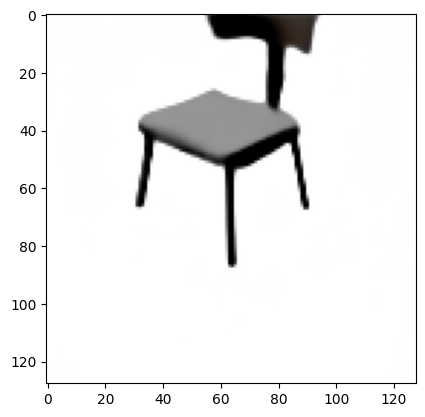

In [22]:
# You can set these to any value you like!
# Positive (negative) values correspond to moving camera to the right (left)
azimuth_shift = torch.Tensor([0.]).to(device)  
# Positive (negative) values correspond to moving camera up (down)
elevation_shift = torch.Tensor([0.]).to(device)
# Translation values
translations_shift = torch.Tensor([0., 0.5, 0.]).to(device)

azimuth_target = azimuth_source + azimuth_shift
elevation_target = elevation_source + elevation_shift
translations_target = translations_source + translations_shift

# Rotate scene to match target camera angle
rotated_scene = model.rotate_source_to_target(
    scene, 
    azimuth_source, elevation_source, translations_source,
    azimuth_target, elevation_target, translations_target
)

# Render rotated scene
rendered = model.render(rotated_scene)

plot_img_tensor(rendered.detach())

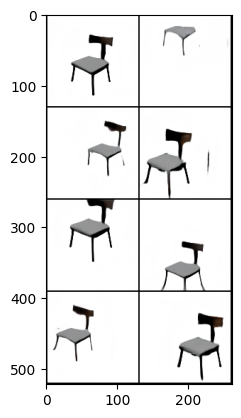

In [23]:
from misc.viz import generate_novel_views

# We can also generate several novel views of the same object
azimuth_shifts = torch.Tensor([20., -50., 120., 180., -90., 50.]).to(device)
elevation_shifts = torch.Tensor([10., -30., 40., -70., 10., 30.]).to(device)


translations_shifts = torch.Tensor([
    [0., 0., 0.],
    [0.5, 0.5, 0.5],
    [0.5, 0., 0.],
    [-0.5, 0., 0.],
    [0., 0.5, 0.],
    [0., -0.5, 0.],
    [0., 0., 0.5],
    [0., 0., -0.5],
]).to(device)

azimuth_shifts   = torch.zeros(len(translations_shifts)).to(device)
elevation_shifts = torch.zeros(len(translations_shifts)).to(device)

# This function expects a single image as input, so remove batch dimension
views = generate_novel_views(model, img_source[0], 
                             azimuth_source, elevation_source, translations_source,
                             azimuth_shifts, elevation_shifts, translations_shifts)

plot_img_tensor(views.detach(), nrow=2)

## Generate novel view animation

In [24]:
from misc.utils import full_rotation_angle_sequence, sine_squared_angle_sequence, back_and_forth_angle_sequence
from misc.viz import batch_generate_novel_views, save_img_sequence_as_gif

# num_frames = 25
# azimuth_shifts = full_rotation_angle_sequence(num_frames).to(device)
# elevation_shifts = sine_squared_angle_sequence(num_frames, -10., 20.).to(device)

back_and_forth = back_and_forth_angle_sequence(10, 0, .5)
zeros = torch.zeros(len(back_and_forth))

translations_shifts = torch.stack((
    torch.cat((back_and_forth, zeros, zeros), dim = 0),
    torch.cat((zeros, back_and_forth, zeros), dim = 0),
    torch.cat((zeros, zeros, back_and_forth), dim = 0),
), dim = 1).to(device)

azimuth_shifts   = torch.zeros(len(translations_shifts)).to(device)
elevation_shifts = torch.zeros(len(translations_shifts)).to(device)




views = batch_generate_novel_views(model, img_source, 
                                   azimuth_source, elevation_source, translations_source,
                                   azimuth_shifts, elevation_shifts, translations_shifts)

# Save generated gif (this gif will display in the next cell once it has been saved)
save_img_sequence_as_gif(views, 'imgs/novel_views_example.gif')

![chairs-gif](./novel_views_example.gif "chairs-gif")